In [1]:
! git clone https://github.com/lu0x1a0/EURUSDPriceAnalysis.git

Cloning into 'EURUSDPriceAnalysis'...
remote: Enumerating objects: 188, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 188 (delta 39), reused 93 (delta 27), pack-reused 80
Receiving objects: 100% (188/188), 48.33 MiB | 16.71 MiB/s, done.
Resolving deltas: 100% (77/77), done.
Checking out files: 100% (45/45), done.


In [3]:
!mv EURUSDPriceAnalysis/* .

In [2]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3
import talib
!pip install numpy==1.20.0
!pip install torchinfo

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3765    0  3765    0     0  16298      0 --:--:-- --:--:-- --:--:-- 16298
100  503k  100  503k    0     0   714k      0 --:--:-- --:--:-- --:--:-- 3346k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3773    0  3773    0     0  18139      0 --:--:-- --:--:-- --:--:-- 18139
100  406k  100  406k    0     0   605k      0 --:--:-- --:--:-- --:--:-- 1086k
     |████████████████████████████████| 15.3 MB 70 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depende

In [1]:
from DataManipulation.DataHandler import getOHLC_pickle, getOHLC_raw
#data = getOHLC_pickle("EURUSD_M_2010_2021.pkl")
data = getOHLC_raw()
data = data.resample('1H').agg({'Open': 'first', 
                        'High': 'max', 
                        'Low': 'min', 
                        'Close': 'last'}).dropna()

In [2]:
#generates the indicators
from DataManipulation.indicators import DEMA, D1, MaxMinRollNorm
demaperiod = [9]
for p in demaperiod:
    data['dema'+str(p)] = DEMA(data['Close'],p)
    data['D1dema'+str(p)] = D1(data['dema'+str(p)])
#    data['normD1dema'+str(p)] = MaxMinRollNorm(data['D1dema'+str(p)], 24*250) # 250 approximated larger than all trading days in a year

stdperiod = [9,100,300]
for p in stdperiod:
    data['std'+str(p)+"_dema9"]  = data['dema9'].rolling(p).std()
    data['std'+str(p)+"_D1dema9"]= data['D1dema9'].rolling(p).std()
print(data.columns)

Index(['Open', 'High', 'Low', 'Close', 'dema9', 'D1dema9', 'std9_dema9',
       'std9_D1dema9', 'std100_dema9', 'std100_D1dema9', 'std300_dema9',
       'std300_D1dema9'],
      dtype='object')


In [ ]:
#import numpy as np
#import pandas as pd
#x = pd.Series([np.nan,1,2,3,4,5,6,7,8,9])
#y = pd.Series([np.nan,2,3,4,5,6,7,8,9,10])
#print((x[1:]-y[:-1]).shape)
#print((x[1:]-y[:-1]))
#print((x[1:].to_numpy()-y[:-1].to_numpy()))

In [3]:
import pandas as pd
prediction_ind = ['D1dema9','std9_dema9','std9_D1dema9', 'std100_dema9', 'std100_D1dema9', 'std300_dema9','std300_D1dema9']
preds = pd.DataFrame()
for n in prediction_ind:
    preds[n+"_norm"] = MaxMinRollNorm(data[n], 24*250)
preds.tail()

,D1dema9_norm,std9_dema9_norm,std9_D1dema9_norm,std100_dema9_norm,std100_D1dema9_norm,std300_dema9_norm,std300_D1dema9_norm
Date,,,,,,,
2021-09-30 19:00:00,0.549541,0.035342,0.157625,0.417056,0.216130,0.387081,0.228713
2021-09-30 20:00:00,0.509068,0.031738,0.166833,0.421059,0.216888,0.390208,0.211806
2021-09-30 21:00:00,0.593398,0.035424,0.145746,0.424265,0.215617,0.392990,0.210738
2021-09-30 22:00:00,0.599056,0.033126,0.123020,0.426708,0.215817,0.395560,0.211329
2021-09-30 23:00:00,0.585908,0.033670,0.104754,0.428453,0.214252,0.397978,0.211484


In [9]:
#import matplotlib.pyplot as plt
#plt.plot(preds['D1dema9_norm'].iloc[:]) # might consider to only divide, not subtract minimum as direction might be useful?
#plt.show()
#plt.plot(preds['std9_dema9_norm'].iloc[-500:])
#plt.show()
#plt.plot(preds['std100_dema9_norm'].iloc[-1000:])
#plt.show()

In [4]:
from numpy.lib.stride_tricks import sliding_window_view
raw =  preds.dropna().to_numpy()
wind = sliding_window_view(raw,window_shape = 3*5*24, axis=0)
#print(wind[-1,:])
print(wind.shape)
#print(wind[~pd.isna(wind)].shape)
x = wind[:-1,:]
target_column = "std100_dema9_norm"
y = wind[1:,3,-1]
print(x.shape,y.shape)

(66390, 7, 360)
(66389, 7, 360) (66389,)


In [5]:
from torch.utils.data import TensorDataset
import torch
train_x = torch.Tensor(x[0:int(len(x)*0.7),])
train_y = torch.Tensor(y[0:int(len(x)*0.7)]).unsqueeze(1)
test_x  = torch.Tensor(x[int(len(x)*0.7):,])
test_y  = torch.Tensor(y[int(len(x)*0.7):]).unsqueeze(1)

train_dataset = TensorDataset(torch.Tensor(x[0:int(len(x)*0.7),]),torch.Tensor(y[0:int(len(x)*0.7)]).unsqueeze(1) )
test_dataset =  TensorDataset(torch.Tensor(x[int(len(x)*0.7):,]), torch.Tensor(y[int(len(x)*0.7):]).unsqueeze(1) )

trainloader = torch.utils.data.DataLoader(train_dataset,
                            batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader(test_dataset,
                            batch_size=32, shuffle=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
import torch
from torch import optim
from Models.neural import STDConvModel
model = STDConvModel(3*5*24, 7, 12,stride1=2,stride2=2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = model.to(device)
print(next(net.parameters()).is_cuda)
class reverseKLD(torch.nn.Module):
    """
    Class for creating a custom loss function, if desired.
    If you instead specify a standard loss function,
    you can remove or comment out this class.
    """
    def __init__(self):
        super(reverseKLD, self).__init__()
        self.loss = torch.nn.KLDivLoss()
    def forward(self, output, target):
        #return torch.mean((output - target)**2)
        return self.loss(target,output)
criterion = reverseKLD()
optimiser = optim.Adam(net.parameters())

tensor([[0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173],
        [0.4173]], grad_fn=<SigmoidBackward0>)
True


In [7]:
def test_network(net,testloader, criterion):
    net.eval()
    total_images = 0
    #total_correct = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
    #        _, predicted = torch.max(outputs.data, 1)
            loss = criterion(output,labels)
            total_images += labels.size(0)
    #        total_correct += (predicted == labels).sum().item()

    model_accuracy = 0 / total_images * 100
    #print('      Accuracy on {0} test images: {1:.2f}%'.format(
    #                            total_images, model_accuracy))
    print("Test Loss: ", loss)
    net.train()

In [9]:
print("Start training...")
for epoch in range(0,100):
    total_loss = 0
    total_timeframes = 0
    #total_correct = 0
    i = 0
    for batch in trainloader:           # Load batch
        batch_x, batch_y = batch 
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print([x.get_device() for x in net.parameters()])
        #print(next(net.parameters()).is_cuda)
        #print(batch_x.get_device())
        preds = net(batch_x)             # Process batch
        loss = criterion(preds, batch_y) # Calculate loss
        i += 1
        optimiser.zero_grad()
        loss.backward()                 # Calculate gradients
        optimiser.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_timeframes += batch_y.size(0)

    print('epoch {0} total_correct: {1} loss: {2:.2f} acc: {3:.2f}'.format(
                epoch,-1, total_loss, -1) )

Start training...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2748: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  "reduction: 'mean' divides the total loss by both the batch size and the support size."


epoch 0 total_correct: -1 loss: -705.67 acc: -1.00
epoch 1 total_correct: -1 loss: -705.92 acc: -1.00
epoch 2 total_correct: -1 loss: -705.98 acc: -1.00
epoch 3 total_correct: -1 loss: -706.05 acc: -1.00
epoch 4 total_correct: -1 loss: -706.05 acc: -1.00
epoch 5 total_correct: -1 loss: -706.13 acc: -1.00
epoch 6 total_correct: -1 loss: -706.16 acc: -1.00
epoch 7 total_correct: -1 loss: -706.10 acc: -1.00
epoch 8 total_correct: -1 loss: -705.99 acc: -1.00
epoch 9 total_correct: -1 loss: -706.07 acc: -1.00
epoch 10 total_correct: -1 loss: -706.12 acc: -1.00
epoch 11 total_correct: -1 loss: -706.12 acc: -1.00
epoch 12 total_correct: -1 loss: -706.18 acc: -1.00
epoch 13 total_correct: -1 loss: -706.20 acc: -1.00
epoch 14 total_correct: -1 loss: -706.18 acc: -1.00
epoch 15 total_correct: -1 loss: -706.21 acc: -1.00
epoch 16 total_correct: -1 loss: -706.22 acc: -1.00
epoch 17 total_correct: -1 loss: -706.18 acc: -1.00
epoch 18 total_correct: -1 loss: -706.19 acc: -1.00
epoch 19 total_correct

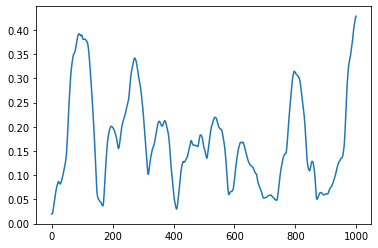

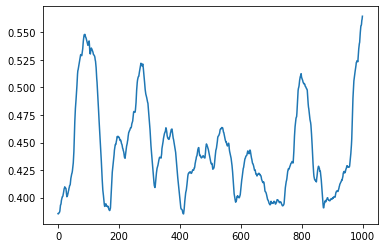

In [19]:
import matplotlib.pyplot as plt
from torch import nn
plt.plot(test_y[-1000:])
plt.show()
pred = net(test_x.to(device))
plt.plot(pred.detach().cpu().numpy()[-1000:])

#print(test_y.shape)
#print(net(test_x).detach().numpy().shape)
#print(net(test_x).detach().numpy()[-20:])
#print(nn.BatchNorm1d(net.num_features+1)(nn.ReLU()(net.conv1d(test_x[-1:,]))))
#import numpy as np
#np.set_printoptions(threshold=10_000)
#print(test_x[-1:,].shape)
#print(test_x[-1:,:,0])
#print(test_x[-1:,:,-1])
#print(net.conv1d)
#print(net.conv1d(test_x[-1:,]).shape)


In [20]:
import torch
from torch import optim, nn
from Models.neural import STDConvModel
model = STDConvModel(3*5*24, 7, 12,stride1=2,stride2=2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = model.to(device)
criterion = nn.MSELoss()
optimiser = optim.Adam(net.parameters())

In [21]:
print("Start training...")
for epoch in range(0,100):
    total_loss = 0
    total_timeframes = 0
    #total_correct = 0
    i = 0
    for batch in trainloader:           # Load batch
        batch_x, batch_y = batch 
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print([x.get_device() for x in net.parameters()])
        #print(next(net.parameters()).is_cuda)
        #print(batch_x.get_device())
        preds = net(batch_x)             # Process batch
        loss = criterion(preds, batch_y) # Calculate loss
        i += 1
        optimiser.zero_grad()
        loss.backward()                 # Calculate gradients
        optimiser.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_timeframes += batch_y.size(0)

    print('epoch {0} total_correct: {1} loss: {2:.2f} acc: {3:.2f}'.format(
                epoch,-1, total_loss, -1) )

Start training...
epoch 0 total_correct: -1 loss: 4.93 acc: -1.00
epoch 1 total_correct: -1 loss: 1.64 acc: -1.00
epoch 2 total_correct: -1 loss: 1.44 acc: -1.00
epoch 3 total_correct: -1 loss: 1.35 acc: -1.00
epoch 4 total_correct: -1 loss: 1.27 acc: -1.00
epoch 5 total_correct: -1 loss: 1.24 acc: -1.00
epoch 6 total_correct: -1 loss: 1.15 acc: -1.00
epoch 7 total_correct: -1 loss: 1.15 acc: -1.00
epoch 8 total_correct: -1 loss: 1.10 acc: -1.00
epoch 9 total_correct: -1 loss: 1.07 acc: -1.00
epoch 10 total_correct: -1 loss: 1.02 acc: -1.00
epoch 11 total_correct: -1 loss: 1.05 acc: -1.00
epoch 12 total_correct: -1 loss: 1.03 acc: -1.00
epoch 13 total_correct: -1 loss: 1.02 acc: -1.00
epoch 14 total_correct: -1 loss: 1.00 acc: -1.00
epoch 15 total_correct: -1 loss: 0.97 acc: -1.00
epoch 16 total_correct: -1 loss: 0.94 acc: -1.00
epoch 17 total_correct: -1 loss: 0.93 acc: -1.00
epoch 18 total_correct: -1 loss: 0.91 acc: -1.00
epoch 19 total_correct: -1 loss: 0.93 acc: -1.00
epoch 20 tot

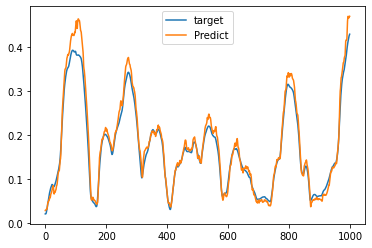

In [26]:
import matplotlib.pyplot as plt
from torch import nn
fig, ax = plt.subplots()
ax.plot(test_y[-1000:],label='target')
#plt.show()
pred = net(test_x.to(device))
ax.plot(pred.detach().cpu().numpy()[-1000:],label='Predict')
ax.legend()


In [30]:
import torch
from torch import optim, nn
from Models.neural import STDConvModel
model = STDConvModel(3*5*24, 7, 12,stride1=2,stride2=2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = model.to(device)
criterion = nn.BCELoss()
optimiser = optim.Adam(net.parameters())

In [31]:
print("Start training...")
for epoch in range(0,100):
    total_loss = 0
    total_timeframes = 0
    #total_correct = 0
    i = 0
    for batch in trainloader:           # Load batch
        batch_x, batch_y = batch 
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print([x.get_device() for x in net.parameters()])
        #print(next(net.parameters()).is_cuda)
        #print(batch_x.get_device())
        preds = net(batch_x)             # Process batch
        loss = criterion(preds, batch_y) # Calculate loss
        i += 1
        optimiser.zero_grad()
        loss.backward()                 # Calculate gradients
        optimiser.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_timeframes += batch_y.size(0)

    print('epoch {0} total_correct: {1} loss: {2:.2f} acc: {3:.2f}'.format(
                epoch,-1, total_loss, -1) )

Start training...
epoch 0 total_correct: -1 loss: 735.84 acc: -1.00
epoch 1 total_correct: -1 loss: 726.45 acc: -1.00
epoch 2 total_correct: -1 loss: 725.54 acc: -1.00
epoch 3 total_correct: -1 loss: 725.02 acc: -1.00
epoch 4 total_correct: -1 loss: 724.90 acc: -1.00
epoch 5 total_correct: -1 loss: 724.75 acc: -1.00
epoch 6 total_correct: -1 loss: 724.52 acc: -1.00
epoch 7 total_correct: -1 loss: 724.51 acc: -1.00
epoch 8 total_correct: -1 loss: 724.34 acc: -1.00
epoch 9 total_correct: -1 loss: 724.09 acc: -1.00
epoch 10 total_correct: -1 loss: 724.08 acc: -1.00
epoch 11 total_correct: -1 loss: 724.05 acc: -1.00
epoch 12 total_correct: -1 loss: 723.98 acc: -1.00
epoch 13 total_correct: -1 loss: 723.88 acc: -1.00
epoch 14 total_correct: -1 loss: 723.78 acc: -1.00
epoch 15 total_correct: -1 loss: 723.75 acc: -1.00
epoch 16 total_correct: -1 loss: 723.65 acc: -1.00
epoch 17 total_correct: -1 loss: 723.63 acc: -1.00
epoch 18 total_correct: -1 loss: 723.55 acc: -1.00
epoch 19 total_correct:

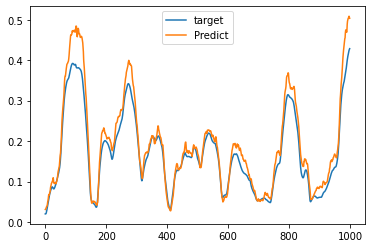

In [34]:
import matplotlib.pyplot as plt
from torch import nn
fig, ax = plt.subplots()
ax.plot(test_y[-1000:],label='target')
#plt.show()
pred = net(test_x.to(device))
ax.plot(pred.detach().cpu().numpy()[-1000:],label='Predict')
ax.legend()
